<a href="https://colab.research.google.com/github/NehaSontakk/BATH-Prokka-Comparison/blob/main/Updated_Contig_comparison_identifying_gaps_Prokka_vs_BATH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alignment and Classification of BATH and Prokka Annotations

Script performs a comprehensive comparison between genomic annotations produced by Prokka and BATH.

For both BATH and Prokka outputs. The code generates BED files for different genomic regions, segregates them based on DNA strands, and runs operations to find overlaps and unique annotations between the two datasets using the bedops suite of tools.

It combines the resulting files by prefix, ensuring that all directories are created if they don't exist. Finally, the code analyzes the overlapping and unique regions, categorizes them, and visualizes the data with a Venn diagram to provide insights into overlap classification catrgory of each annotation.

In [91]:
#Installations
!pip install gffpandas
!sudo apt-get install bedops
!pip install biopython

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
bedops is already the newest version (2.4.40+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import subprocess
import matplotlib.pyplot as plt
import gffpandas.gffpandas as gffpd
from Bio import SeqIO
from glob import glob
from pathlib import Path

In [93]:
#Input file paths
prokka_annotations = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Prokka Output/bin152.gff'
bath_dedup_annotations = "/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Deduplication Output/dedup_bin52_test1.xlsx"
list_of_bathsearch_outputs = glob("/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Bathsearch Output/*")
#Output files
prokka_annotations_save = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Prokka Output/Prokka_proteins_bin152.xlsx'
bath_dedup_annotations_save = "/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Deduplication Output/BATH_proteins_bin152.xlsx"
bath_prokka_alignment = "/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Aligned Outputs/Aligned_Outputs_bin152.xlsx"
bathsearch_output_file = "bathsearch_combined_file.csv"

In [94]:
#Load and prep the prokka files
annotation = gffpd.read_gff3(prokka_annotations)
combined_df = annotation.filter_feature_of_type(['CDS'])
attr_to_columns = combined_df.attributes_to_columns()
prokka_proteins = pd.DataFrame(attr_to_columns)
prokka_proteins['start'] = prokka_proteins['start'].astype(int)
prokka_proteins['end'] = prokka_proteins['end'].astype(int)

In [95]:
prokka_proteins.head()

,seq_id,source,type,start,end,score,strand,phase,attributes,ID,Name,db_xref,eC_number,gene,inference,locus_tag,note,product
0,k127_1202428,Prodigal:002006,CDS,149,616,.,-,0,ID=JNLINIBG_00001;inference=ab initio predicti...,JNLINIBG_00001,None,None,None,None,ab initio prediction:Prodigal:002006,JNLINIBG_00001,None,hypothetical protein
1,k127_1202428,Prodigal:002006,CDS,936,1466,.,+,0,ID=JNLINIBG_00002;eC_number=3.4.25.2;Name=hslV...,JNLINIBG_00002,hslV,COG:COG5405,3.4.25.2,hslV,"ab initio prediction:Prodigal:002006,similar t...",JNLINIBG_00002,None,ATP-dependent protease subunit HslV
2,k127_1202428,Prodigal:002006,CDS,1466,2821,.,+,0,ID=JNLINIBG_00003;Name=clpY;db_xref=COG:COG122...,JNLINIBG_00003,clpY,COG:COG1220,None,clpY,"ab initio prediction:Prodigal:002006,similar t...",JNLINIBG_00003,None,ATP-dependent protease ATPase subunit ClpY
3,k127_1202428,Prodigal:002006,CDS,3069,4058,.,+,0,ID=JNLINIBG_00004;eC_number=6.3.4.15;Name=birA...,JNLINIBG_00004,birA,COG:COG0340,6.3.4.15,birA,"ab initio prediction:Prodigal:002006,similar t...",JNLINIBG_00004,None,Bifunctional ligase/repressor BirA
4,k127_1202428,Prodigal:002006,CDS,4169,4738,.,+,0,ID=JNLINIBG_00005;Name=bioY_1;db_xref=COG:COG1...,JNLINIBG_00005,bioY_1,COG:COG1268,None,bioY_1,"ab initio prediction:Prodigal:002006,similar t...",JNLINIBG_00005,None,Biotin transporter BioY


In [96]:
#Load and prep bath files
bath_protein = pd.read_excel(bath_dedup_annotations)
unnamed_cols = [col for col in bath_protein.columns if col.startswith('Unnamed')]
bath_protein.drop(columns=unnamed_cols, inplace=True)
bath_protein['start'] = bath_protein['ali from']
bath_protein['end'] = bath_protein['ali to']
bath_protein['start'].fillna(bath_protein['ali from flip'],inplace=True)
bath_protein['end'].fillna(bath_protein['ali to flip'],inplace=True)
bath_protein['ID'] = bath_protein['query name']

In [97]:
bath_protein[bath_protein['query name'].str.startswith("IS")]

,target name,accession,query name,accession1,hmm len,hmm from,hmm to,seq len,ali from,ali to,...,shifts,stops,pipe,description of target,strand,ali from flip,ali to flip,start,end,ID
2,k127_239001,-,ISBsp7,-,299,8,283,136989,47843,48661,...,6,0,fs,-,+,NaN,NaN,47843,48661,ISBsp7
80,k127_1112543,-,ISDsu1,-,487,454,487,2176,1,102,...,0,0,std,-,+,NaN,NaN,1,102,ISDsu1
154,k127_2033476,-,ISDsu1,-,487,443,487,85870,1,135,...,0,0,std,-,+,NaN,NaN,1,135,ISDsu1
209,k127_2033476,-,ISDsu1,-,487,1,197,85870,85280,85870,...,0,1,fs,-,+,NaN,NaN,85280,85870,ISDsu1


In [98]:
bath_protein.columns

Index(['target name', 'accession', 'query name', 'accession1', 'hmm len',
       'hmm from', 'hmm to', 'seq len', 'ali from', 'ali to', 'env from',
       'env to', 'E-value', 'score', 'bias', 'shifts', 'stops', 'pipe',
       'description of target', 'strand', 'ali from flip', 'ali to flip',
       'start', 'end', 'ID'],
      dtype='object')

In [99]:
bath_protein.shape

(508, 25)

In [100]:
prokka_proteins.shape

(627, 18)

### Remove IS elements from both Prokka and BATH data

In [101]:
bath_protein = bath_protein[~bath_protein['query name'].str.startswith("IS")]

In [102]:
prokka_proteins = prokka_proteins[~prokka_proteins['inference'].str.contains("ISfinder")]

### Save new bath and prokka protein files

In [103]:
bath_protein.to_excel(bath_dedup_annotations_save,index=False)
prokka_proteins.to_excel(prokka_annotations_save,index=False)

## Find the gaps filled by BATH vs Prokka per contig

In [104]:
# Separate BATH data into positive and negative strands
pos_strand = bath_protein[bath_protein['strand'] == "+"].copy()
neg_strand = bath_protein[bath_protein['strand'] == "-"].copy()

# Handle columns for positive strand
pos_strand.loc[:, 'start'] = pos_strand['ali from'].astype(int)
pos_strand.loc[:, 'end'] = pos_strand['ali to'].astype(int)

# Handle columns for negative strand
neg_strand.loc[:, 'start'] = neg_strand['ali from flip'].astype(int)
neg_strand.loc[:, 'end'] = neg_strand['ali to flip'].astype(int)

# Filter Prokka proteins into positive and negative strands
prokka_proteins_plus = prokka_proteins[prokka_proteins['strand'] == '+'].copy()
prokka_proteins_minus = prokka_proteins[prokka_proteins['strand'] == '-'].copy()

# Sort and save positive strand Prokka proteins
prokka_proteins_plus.sort_values('start', inplace=True)
prokka_proteins_plus.to_csv('prokka_proteins_plus.bed', sep='\t', index=False, header=False, columns=['seq_id', 'start', 'end', 'strand', 'ID', 'inference'])

# Sort and save negative strand Prokka proteins
prokka_proteins_minus.sort_values('start', inplace=True)
prokka_proteins_minus.to_csv('prokka_proteins_minus.bed', sep='\t', index=False, header=False, columns=['seq_id', 'start', 'end', 'strand', 'ID', 'inference'])

# Sort and save BATH deduplicated positive strand
bath_deduplicated_plus = pos_strand[['target name', 'start', 'end', 'strand', 'ID', 'shifts','E-value']].copy()
bath_deduplicated_plus.sort_values('start', inplace=True)
bath_deduplicated_plus.to_csv('bath_deduplicated_plus.bed', sep='\t', index=False, header=False)

# Sort and save BATH deduplicated negative strand
bath_deduplicated_minus = neg_strand[['target name', 'start', 'end', 'strand', 'ID', 'shifts','E-value']].copy()
bath_deduplicated_minus.sort_values('start', inplace=True)
bath_deduplicated_minus.to_csv('bath_deduplicated_minus.bed', sep='\t', index=False, header=False)


### Functions



1.   generate_bed_files:
This function creates BED files by iterating through unique contig identifiers in the DataFrame, filtering and sorting data by start positions, and writing the data to BED files.

2.   run_bedmap_operations:
This function uses bedmap and bedops tools to find overlapping and unique regions between BATH and Prokka BED files. It generates three output files: one for overlaps, one for regions unique to BATH, and one for regions unique to Prokka, saving them in the specified output directory

3.   find_and_process_bed_pairs:
This function finds and pairs BED files from BATH and Prokka directories based on sequence identifiers. It then calls run_bedmap_operations to process each pair, identifying overlaps and unique regions, and saves the results in the output directory.

4.   combine_files_by_prefix:
This function organizes and combines BED files in a source directory by their prefixes. It groups files with the same prefix, concatenates their contents, and writes the combined data into new BED files in the output directory. Each new file is named with the prefix followed by "combined.bed".

In [105]:
#Functions

#generate BED files from a dataframe for each unique sequence identifier (contig) present in the dataframe.
def generate_bed_files(df, directory, contig_column, file_prefix='Prokka_annotation'):
    # Generates BED files for each unique 'seq_id' in the DataFrame.
    os.makedirs(directory, exist_ok=True)
    for seq_id in df[contig_column].unique():
        df_seq = df[df[contig_column] == seq_id]
        #print(df_seq.shape)
        df_seq = df[df[contig_column] == seq_id].sort_values(by=['start'])
        filename = f'{directory}/{file_prefix}_{seq_id}.bed'
        with open(filename, 'w') as file:
            for _, row in df_seq.iterrows():
              #For a prokka file
              if file_prefix == "Prokka_annotation":
                bed_line = f"{row[contig_column]}\t{row['start']}\t{row['end']}\t{row['ID']}\t{row['strand']}\t{row['inference']}\n"
                file.write(bed_line)
              else:
                #For a BATH file
                bed_line = f"{row[contig_column]}\t{row['start']}\t{row['end']}\t{row['ID']}\t{row['strand']}\t{row['shifts']}\t{row['E-value']}\n"
                file.write(bed_line)

    print(f"BED files have been successfully generated in {directory}")

def run_bedmap_operations(bath_bed_path, prokka_bed_path, output_base_dir):
    seq_id = bath_bed_path.stem.split('_')[-1]
    overlap_output = output_base_dir / f'overlap_prokka_bath_{seq_id}.bed'
    unique_to_bath_output = output_base_dir / f'unique_to_bath_{seq_id}.bed'
    unique_to_prokka_output = output_base_dir / f'unique_to_prokka_{seq_id}.bed'

    output_base_dir.mkdir(parents=True, exist_ok=True)

    # Command for bedmap to find overlaps
    command = [
        "bedmap", "--echo", "--echo-map", "--delim", ";",
        "--fraction-ref", "0.15",
        str(bath_bed_path), str(prokka_bed_path)
    ]

    # Run the command and capture output
    result = subprocess.run(command, capture_output=True, text=True, check=True)

    # Filter the output and write to overlap_output
    with open(overlap_output, 'w') as f_output:
        for line in result.stdout.splitlines():
            parts = line.split(';')
            # Check if there is more than one part and the second part is not empty
            if len(parts) > 1 and parts[1].strip():
                f_output.write(line + '\n')

    # Run bedmap for unique to BATH
    subprocess.run(["bedops", "--not-element-of", "1", str(bath_bed_path), str(prokka_bed_path)], stdout=open(unique_to_bath_output, 'w'), check=True)

    # Run bedmap for unique to Prokka
    subprocess.run(["bedops", "--not-element-of", "1", str(prokka_bed_path), str(bath_bed_path)], stdout=open(unique_to_prokka_output, 'w'), check=True)

def find_and_process_bed_pairs(bath_dir, prokka_dir, output_dir):
    bath_dir_path = Path(bath_dir)
    prokka_dir_path = Path(prokka_dir)
    output_base_dir = Path(output_dir)

    bath_bed_files = {f.stem.split('_')[-1]: f for f in bath_dir_path.glob('BATH_annotation_*.bed')}
    prokka_bed_files = {f.stem.split('_')[-1]: f for f in prokka_dir_path.glob('Prokka_annotation_*.bed')}

    for seq_id, bath_bed_path in bath_bed_files.items():
        print(seq_id)
        prokka_bed_path = prokka_bed_files.get(seq_id)
        print("Processing files ... ",prokka_bed_path, "and ",bath_bed_path)
        if prokka_bed_path:
            run_bedmap_operations(bath_bed_path, prokka_bed_path, output_base_dir)
        else:
            print(f"No matching Prokka file found for BATH seq_id: {seq_id}")

def combine_files_by_prefix(source_directory, output_directory, prefixes):
    source_directory = Path(source_directory)
    output_directory = Path(output_directory)
    output_directory.mkdir(parents=True, exist_ok=True)
    file_groups = {prefix: [] for prefix in prefixes}
    for file_path in source_directory.glob('*.bed'):
        for prefix in prefixes:
            if file_path.name.startswith(prefix):
                file_groups[prefix].append(file_path)
    for prefix, files in file_groups.items():
        combined_file_path = output_directory / f"{prefix}combined.bed"
        with combined_file_path.open('w') as combined_file:
            for file_path in files:
                with file_path.open() as input_file:
                    combined_file.write(input_file.read())
                combined_file.write('\n')

In [106]:
import os

BASE_DIR = '/content/BED'
PROKKA_PLUS_DIR = f'{BASE_DIR}/Prokka_Annotation_PLUS_BED'
PROKKA_MINUS_DIR = f'{BASE_DIR}/Prokka_Annotation_MINUS_BED'
BATH_PLUS_DIR = f'{BASE_DIR}/BATH_Annotation_PLUS_BED'
BATH_MINUS_DIR = f'{BASE_DIR}/BATH_Annotation_MINUS_BED'
OVERLAPS_DIR = f'{BASE_DIR}/Overlaps and Differences'
COMBINED_FILES_DIR = f'{BASE_DIR}/Combined Files'


directories = [
    PROKKA_PLUS_DIR, PROKKA_MINUS_DIR,
    BATH_PLUS_DIR, BATH_MINUS_DIR,
    OVERLAPS_DIR, COMBINED_FILES_DIR
]
for directory in directories:
    os.makedirs(directory, exist_ok=True)


generate_bed_files(prokka_proteins_plus, PROKKA_PLUS_DIR, 'seq_id', file_prefix='Prokka_annotation')
generate_bed_files(prokka_proteins_minus, PROKKA_MINUS_DIR, 'seq_id', file_prefix='Prokka_annotation')
generate_bed_files(bath_deduplicated_plus, BATH_PLUS_DIR, 'target name', file_prefix='BATH_annotation')
generate_bed_files(bath_deduplicated_minus, BATH_MINUS_DIR, 'target name', file_prefix='BATH_annotation')


find_and_process_bed_pairs(BATH_PLUS_DIR, PROKKA_PLUS_DIR, OVERLAPS_DIR)

prefixes = ['unique_to_prokka_', 'unique_to_bath_', 'overlap_prokka_bath_']
combine_files_by_prefix(OVERLAPS_DIR, COMBINED_FILES_DIR, prefixes)

BED files have been successfully generated in /content/BED/Prokka_Annotation_PLUS_BED
BED files have been successfully generated in /content/BED/Prokka_Annotation_MINUS_BED
BED files have been successfully generated in /content/BED/BATH_Annotation_PLUS_BED
BED files have been successfully generated in /content/BED/BATH_Annotation_MINUS_BED
1510713
Processing files ...  /content/BED/Prokka_Annotation_PLUS_BED/Prokka_annotation_k127_1510713.bed and  /content/BED/BATH_Annotation_PLUS_BED/BATH_annotation_k127_1510713.bed
239001
Processing files ...  /content/BED/Prokka_Annotation_PLUS_BED/Prokka_annotation_k127_239001.bed and  /content/BED/BATH_Annotation_PLUS_BED/BATH_annotation_k127_239001.bed
2652665
Processing files ...  /content/BED/Prokka_Annotation_PLUS_BED/Prokka_annotation_k127_2652665.bed and  /content/BED/BATH_Annotation_PLUS_BED/BATH_annotation_k127_2652665.bed
1278307
Processing files ...  /content/BED/Prokka_Annotation_PLUS_BED/Prokka_annotation_k127_1278307.bed and  /content

### Analysis

#### Venn diagram of region based overlaps

In [107]:
def transform_file_to_dataframe(file_path):
    transformed_rows = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Check if the file is empty
        if not lines:
            raise f"The file '{file_path}' is empty."

        for line in lines:
            fields = line.strip().split(';')
            if len(fields) == 3:
                new_row1 = [fields[0], fields[1]]
                new_row2 = [fields[0], fields[2]]
                transformed_rows.append(new_row1)
                transformed_rows.append(new_row2)
            else:
                transformed_rows.append(fields)

    valid_rows = [row for row in transformed_rows if len(row) == 2]

    df = pd.DataFrame(valid_rows, columns=['BATH', 'Prokka']).replace("\n", np.nan).dropna()

    return df

In [108]:
file_path = '/content/BED/Combined Files/overlap_prokka_bath_combined.bed'
overlaps = transform_file_to_dataframe(file_path)

In [109]:
def determine_label(row):
    if row['Prokka'].endswith('ab initio prediction:Prodigal:002006'):
        return "BATH and Prokka Unannotated"
    else:
        return "BATH and Prokka Annotated"

overlaps['label'] = overlaps.apply(determine_label, axis=1)

In [110]:
file_path = '/content/BED/Combined Files/unique_to_bath_combined.bed'
with open(file_path, 'r') as file:
    lines = [line.strip() for line in file.readlines() if line.strip()]
unique_to_bath = pd.DataFrame(lines, columns=['BATH']).replace("\n",np.nan).dropna()
unique_to_bath['Prokka'] = np.nan
unique_to_bath['label'] = 'BATH'

In [111]:
file_path3 = '/content/BED/Combined Files/unique_to_prokka_combined.bed'
with open(file_path3, 'r') as file:
    lines = [line.strip() for line in file.readlines() if line.strip()]
unique_to_prokka = pd.DataFrame(lines, columns=['Prokka']).replace("\n",np.nan).dropna()
unique_to_prokka['BATH'] = np.nan

def determine_label2(row):
    if row['Prokka'].endswith('ab initio prediction:Prodigal:002006'):
        return "Prokka Unannotated"
    else:
        return "Prokka Annotated"

unique_to_prokka['label'] = unique_to_prokka.apply(determine_label2, axis=1)

In [112]:
venn_data = pd.concat([unique_to_prokka,unique_to_bath,overlaps])

In [113]:
venn_data['label'].value_counts()

,count
label,
BATH and Prokka Annotated,276
Prokka Unannotated,79
BATH and Prokka Unannotated,21
Prokka Annotated,5
BATH,3


## Remove alignments identified by Prokka and not BATH because they are closer to the boundary

In [114]:
#Take data from prokka annotated and now go back to prededuplicated data to find alignments to this and then capture the lowest E-value, if this E-value is higher than the threshold then throw away this prokka data
only_prokka_venn = venn_data[venn_data['label'] == "Prokka Annotated"].copy()

In [115]:
only_prokka_venn

,Prokka,BATH,label
0,k127_239001\t1144\t2088\tJNLINIBG_00315\t+\tab...,NaN,Prokka Annotated
17,k127_239001\t76775\t78328\tJNLINIBG_00381\t+\t...,NaN,Prokka Annotated
32,k127_2982141\t15400\t16968\tJNLINIBG_00639\t+\...,NaN,Prokka Annotated
47,k127_1032572\t72257\t72547\tJNLINIBG_00183\t+\...,NaN,Prokka Annotated
49,k127_1032572\t78192\t78452\tJNLINIBG_00191\t+\...,NaN,Prokka Annotated


In [116]:
header = [
    "target name", "accession", "query name", "accession", "hmm len",
    "hmm from", "hmm to", "seq len", "ali from", "ali to",
    "env from", "env to", "E-value", "score", "bias",
    "shifts", "stops", "pipe", "description of target"
]

dataframes = []
for i in list_of_bathsearch_outputs:
    df = pd.read_csv(i, skipfooter=9, skiprows=2, header=None, sep="\s+", engine='python')
    dataframes.append(df)
    #print(df)

combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.columns = header
combined_df.to_csv(bathsearch_output_file, index=False)

combined_df

,target name,accession,query name,accession,hmm len,hmm from,hmm to,seq len,ali from,ali to,env from,env to,E-value,score,bias,shifts,stops,pipe,description of target
0,k127_1510713,-,IS1051,-,343,106,173,74110,871,659,892,641,1.700000e-02,16.3,0.0,0,0,std,-
1,k127_239001,-,IS1141,-,340,18,59,136989,2111,2227,2078,2266,3.700000e-01,13.5,0.0,0,0,std,-
2,k127_1032572,-,IS1230B,-,383,246,310,117210,22497,22694,22458,22718,1.900000e+00,11.6,0.0,0,0,std,-
3,k127_1032572,-,IS1252,-,319,107,142,117210,18975,18868,19020,18832,4.400000e-02,17.5,0.0,0,0,std,-
4,k127_1278307,-,IS1326,-,260,196,238,7809,7447,7319,7495,7307,3.400000e-01,15.7,0.0,0,0,std,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16482,k127_1032572,-,P03890,-,323,6,295,117210,2665,3468,2650,3510,7.300000e-12,53.5,8.1,0,0,std,-
16483,k127_1032572,-,P15548,-,322,4,295,117210,2662,3471,2653,3513,2.500000e-08,41.3,12.8,0,0,std,-
16484,k127_1032572,-,P12772,-,323,3,296,117210,2659,3471,2653,3507,5.700000e-11,50.1,12.6,0,0,std,-
16485,k127_1032572,-,P09045,-,313,3,300,117210,2653,3507,2647,3522,1.000000e-03,26.6,14.7,0,0,std,-


In [117]:
#combined_df[(combined_df['target name'] >= "k127_1032572") & (combined_df['start'] >= 72200) & (combined_df['start'] <= 76200)].sort_values("start")

In [118]:
# Split the 'Prokka' column by '\t' and expand into new columns
expanded_cols = only_prokka_venn['Prokka'].str.split('\t', expand=True)
expanded_cols.columns = ['seq_id', 'start', 'end', 'ID', 'strand', 'inference']
only_prokka_venn = pd.concat([expanded_cols, only_prokka_venn], axis=1)

In [119]:
only_prokka_venn

,seq_id,start,end,ID,strand,inference,Prokka,BATH,label
0,k127_239001,1144,2088,JNLINIBG_00315,+,"ab initio prediction:Prodigal:002006,protein m...",k127_239001\t1144\t2088\tJNLINIBG_00315\t+\tab...,NaN,Prokka Annotated
17,k127_239001,76775,78328,JNLINIBG_00381,+,"ab initio prediction:Prodigal:002006,protein m...",k127_239001\t76775\t78328\tJNLINIBG_00381\t+\t...,NaN,Prokka Annotated
32,k127_2982141,15400,16968,JNLINIBG_00639,+,"ab initio prediction:Prodigal:002006,similar t...",k127_2982141\t15400\t16968\tJNLINIBG_00639\t+\...,NaN,Prokka Annotated
47,k127_1032572,72257,72547,JNLINIBG_00183,+,"ab initio prediction:Prodigal:002006,similar t...",k127_1032572\t72257\t72547\tJNLINIBG_00183\t+\...,NaN,Prokka Annotated
49,k127_1032572,78192,78452,JNLINIBG_00191,+,"ab initio prediction:Prodigal:002006,protein m...",k127_1032572\t78192\t78452\tJNLINIBG_00191\t+\...,NaN,Prokka Annotated


In [120]:
print(only_prokka_venn.columns)
print(only_prokka_venn.columns.duplicated())

Index(['seq_id', 'start', 'end', 'ID', 'strand', 'inference', 'Prokka', 'BATH',
       'label'],
      dtype='object')
[False False False False False False False False False]


In [121]:
only_prokka_venn_pos = only_prokka_venn[only_prokka_venn['strand'] == "+"]
only_prokka_venn_neg = only_prokka_venn[only_prokka_venn['strand'] == "-"]

combined_df['strand'] = np.where(combined_df['ali from'] - combined_df['ali to'] < 0, "-", "+")
combined_df['start'] = combined_df['ali from']
combined_df['end'] = combined_df['ali to']
combined_df['ID'] = combined_df['query name']
combined_df_pos = combined_df[combined_df['strand']=="+"]
combined_df_neg = combined_df[combined_df['strand']=="-"]


In [122]:
# Define directories for separate analysis
SEPARATE_ANALYSIS_DIR = f'{BASE_DIR}/Separate Analysis'
SEPARATE_PROKKA_PLUS_DIR = f'{SEPARATE_ANALYSIS_DIR}/Prokka_Annotation_PLUS_BED'
SEPARATE_PROKKA_MINUS_DIR = f'{SEPARATE_ANALYSIS_DIR}/Prokka_Annotation_MINUS_BED'
SEPARATE_BATH_PLUS_DIR = f'{SEPARATE_ANALYSIS_DIR}/BATH_Annotation_PLUS_BED'
SEPARATE_BATH_MINUS_DIR = f'{SEPARATE_ANALYSIS_DIR}/BATH_Annotation_MINUS_BED'
SEPARATE_OVERLAPS_DIR = f'{SEPARATE_ANALYSIS_DIR}/Overlaps and Differences'
SEPARATE_Combined_DIR = f'{SEPARATE_ANALYSIS_DIR}/Combined Files'
SEPARATE_OVERLAPS_DIR = f'{SEPARATE_ANALYSIS_DIR}/Overlaps and Differences'
SEPARATE_Combined_DIR_OPP = f'{SEPARATE_ANALYSIS_DIR}/Combined Files Opposite Strands'
SEPARATE_OVERLAPS_DIR_OPP = f'{SEPARATE_ANALYSIS_DIR}/Overlaps and Differences Opposite Strands'

In [123]:
separate_directories = [
    SEPARATE_ANALYSIS_DIR, SEPARATE_PROKKA_PLUS_DIR, SEPARATE_PROKKA_MINUS_DIR,
    SEPARATE_BATH_PLUS_DIR, SEPARATE_BATH_MINUS_DIR, SEPARATE_OVERLAPS_DIR, SEPARATE_Combined_DIR, SEPARATE_Combined_DIR_OPP, SEPARATE_OVERLAPS_DIR_OPP
]

for directory in separate_directories:
    os.makedirs(directory, exist_ok=True)

# Generate BED files for Prokka and BATH annotations for both positive and negative strands in the new directories
generate_bed_files(only_prokka_venn_pos, SEPARATE_PROKKA_PLUS_DIR, 'seq_id', file_prefix='Prokka_annotation')
generate_bed_files(only_prokka_venn_neg, SEPARATE_PROKKA_MINUS_DIR, 'seq_id', file_prefix='Prokka_annotation')
generate_bed_files(combined_df_pos, SEPARATE_BATH_PLUS_DIR, 'target name', file_prefix='BATH_annotation')
generate_bed_files(combined_df_neg, SEPARATE_BATH_MINUS_DIR, 'target name', file_prefix='BATH_annotation')

# Process BED pairs to find overlaps and unique regions between BATH and Prokka in the new directories
find_and_process_bed_pairs(SEPARATE_BATH_PLUS_DIR, SEPARATE_PROKKA_PLUS_DIR, SEPARATE_OVERLAPS_DIR)
find_and_process_bed_pairs(SEPARATE_BATH_MINUS_DIR, SEPARATE_PROKKA_MINUS_DIR, SEPARATE_OVERLAPS_DIR)

#Process opposite strand files
find_and_process_bed_pairs(SEPARATE_BATH_MINUS_DIR, SEPARATE_PROKKA_PLUS_DIR, SEPARATE_OVERLAPS_DIR_OPP)
find_and_process_bed_pairs(SEPARATE_BATH_PLUS_DIR, SEPARATE_PROKKA_MINUS_DIR, SEPARATE_OVERLAPS_DIR_OPP)

# Combine resulting BED files by specified prefixes in the new directories
prefixes = ['unique_to_prokka_', 'unique_to_bath_', 'overlap_prokka_bath_']
combine_files_by_prefix(SEPARATE_OVERLAPS_DIR, SEPARATE_Combined_DIR, prefixes)
combine_files_by_prefix(SEPARATE_OVERLAPS_DIR_OPP, SEPARATE_Combined_DIR_OPP, prefixes)

BED files have been successfully generated in /content/BED/Separate Analysis/Prokka_Annotation_PLUS_BED
BED files have been successfully generated in /content/BED/Separate Analysis/Prokka_Annotation_MINUS_BED
BED files have been successfully generated in /content/BED/Separate Analysis/BATH_Annotation_PLUS_BED
BED files have been successfully generated in /content/BED/Separate Analysis/BATH_Annotation_MINUS_BED
1510713
Processing files ...  None and  /content/BED/Separate Analysis/BATH_Annotation_PLUS_BED/BATH_annotation_k127_1510713.bed
No matching Prokka file found for BATH seq_id: 1510713
1510830
Processing files ...  None and  /content/BED/Separate Analysis/BATH_Annotation_PLUS_BED/BATH_annotation_k127_1510830.bed
No matching Prokka file found for BATH seq_id: 1510830
239001
Processing files ...  /content/BED/Separate Analysis/Prokka_Annotation_PLUS_BED/Prokka_annotation_k127_239001.bed and  /content/BED/Separate Analysis/BATH_Annotation_PLUS_BED/BATH_annotation_k127_239001.bed
1278

# Annotations with hits on -ve strands

In [124]:
file_path_prokka_opposite_strand = '/content/BED/Separate Analysis/Combined Files Opposite Strands/overlap_prokka_bath_combined.bed'
overlaps_prokka_opposite_strand = transform_file_to_dataframe(file_path_prokka_opposite_strand)
overlaps_prokka_opposite_strand

,BATH,Prokka
0,k127_1032572\t72260\t72526\tP71376\t-\t0\t9e-05,k127_1032572\t72257\t72547\tJNLINIBG_00183\t+\...
1,k127_1032572\t72260\t72526\tP0AGK4\t-\t0\t3.6e-06,k127_1032572\t72257\t72547\tJNLINIBG_00183\t+\...
2,k127_1032572\t78204\t78443\tMF_02014\t-\t0\t4....,k127_1032572\t78192\t78452\tJNLINIBG_00191\t+\...
3,k127_239001\t1339\t1665\tP9WLC7\t-\t0\t0.00022,k127_239001\t1144\t2088\tJNLINIBG_00315\t+\tab...
4,k127_239001\t1384\t1671\tMF_01260\t-\t0\t0.033,k127_239001\t1144\t2088\tJNLINIBG_00315\t+\tab...
5,k127_239001\t1393\t1665\tO32232\t-\t4\t0.0033,k127_239001\t1144\t2088\tJNLINIBG_00315\t+\tab...
6,k127_239001\t1393\t1695\tQ9KS12\t-\t0\t0.022,k127_239001\t1144\t2088\tJNLINIBG_00315\t+\tab...
7,k127_239001\t1396\t1539\tC6L862\t-\t0\t4.1,k127_239001\t1144\t2088\tJNLINIBG_00315\t+\tab...
8,k127_239001\t1399\t1590\tQ988D4\t-\t0\t6.8,k127_239001\t1144\t2088\tJNLINIBG_00315\t+\tab...
9,k127_239001\t1399\t2022\tQ06174\t-\t6\t0.015,k127_239001\t1144\t2088\tJNLINIBG_00315\t+\tab...


In [125]:
overlaps_prokka_opposite_strand.groupby(['Prokka']).agg(";".join)

,BATH
Prokka,
"k127_1032572\t72257\t72547\tJNLINIBG_00183\t+\tab initio prediction:Prodigal:002006,similar to AA sequence:UniProtKB:P0AGK4",k127_1032572\t72260\t72526\tP71376\t-\t0\t9e-0...
"k127_1032572\t78192\t78452\tJNLINIBG_00191\t+\tab initio prediction:Prodigal:002006,protein motif:HAMAP:MF_02014",k127_1032572\t78204\t78443\tMF_02014\t-\t0\t4....
"k127_239001\t1144\t2088\tJNLINIBG_00315\t+\tab initio prediction:Prodigal:002006,protein motif:HAMAP:MF_01660",k127_239001\t1339\t1665\tP9WLC7\t-\t0\t0.00022...
"k127_239001\t76775\t78328\tJNLINIBG_00381\t+\tab initio prediction:Prodigal:002006,protein motif:HAMAP:MF_01550",k127_239001\t76790\t78223\tMF_01550\t-\t0\t2e-...


In [126]:
columns_to_drop = overlaps_prokka_opposite_strand.groupby(['Prokka']).agg(";".join).index.unique()

In [127]:
venn_data_filtered = venn_data[~venn_data['Prokka'].isin(columns_to_drop)]
print(venn_data_filtered)

                                                Prokka  \
1    k127_239001\t2163\t2588\tJNLINIBG_00316\t+\tab...   
2    k127_239001\t4343\t4615\tJNLINIBG_00319\t+\tab...   
3    k127_239001\t7949\t8092\tJNLINIBG_00325\t+\tab...   
4    k127_239001\t11605\t13338\tJNLINIBG_00329\t+\t...   
5    k127_239001\t13352\t14938\tJNLINIBG_00330\t+\t...   
..                                                 ...   
292  k127_239001\t125438\t125911\tJNLINIBG_00410\t+...   
293  k127_239001\t126069\t127256\tJNLINIBG_00411\t+...   
294  k127_239001\t127266\t130403\tJNLINIBG_00412\t+...   
295  k127_239001\t134649\t136016\tJNLINIBG_00418\t+...   
296  k127_239001\t136078\t136812\tJNLINIBG_00419\t+...   

                                                  BATH  \
1                                                  NaN   
2                                                  NaN   
3                                                  NaN   
4                                                  NaN   
5            

# Annotations with hits having E -values closer to threshold



In [154]:
file_path_prokka_only_same_strand = '/content/BED/Separate Analysis/Combined Files/overlap_prokka_bath_combined.bed'
overlaps_prokka_only_same_strand = transform_file_to_dataframe(file_path_prokka_only_same_strand)
overlaps_prokka_only_same_strand

,BATH,Prokka


In [155]:
def filter_venn_data(overlaps_prokka_only_same_strand):
    filtered_prokka_values = []
    for index, row in overlaps_prokka_only_same_strand.iterrows():
        bath_value = float(row['BATH'].split("\t")[-1])
        if bath_value > 10**-6:
            filtered_prokka_values.append(row['Prokka'])

    filtered_prokka_values = list(set(filtered_prokka_values))

    return filtered_prokka_values


In [156]:
filtered_prokka_values = filter_venn_data(overlaps_prokka_only_same_strand)

In [157]:
venn_data_filtered2 = venn_data_filtered[~venn_data_filtered['Prokka'].isin(filtered_prokka_values)]

# Measuring Overlaps

In [158]:
prokka_unannotated = venn_data_filtered2[venn_data_filtered2['label'] == "Prokka Unannotated"].shape[0]
only_bath = venn_data_filtered2[venn_data_filtered2['label'] == "BATH"].shape[0]
intersection_3 = venn_data_filtered2[venn_data_filtered2['label'] == "BATH and Prokka Annotated"].shape[0]
bath_prokka_unannotated = venn_data_filtered2[venn_data_filtered2['label'] == "BATH and Prokka Unannotated"].shape[0] + venn_data_filtered2[venn_data_filtered2['label'] == "BATH and Prokka Annotated"].shape[0]
prokka_unannot_annot = venn_data_filtered2[venn_data_filtered2['label'] == "Prokka Annotated"].shape[0]


<ipython-input-159-f8cffa90a889>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


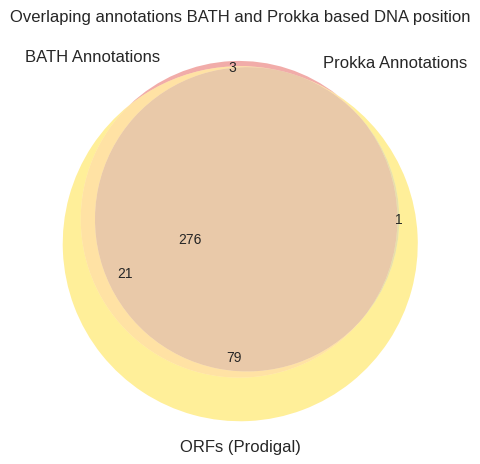

In [159]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

plt.style.use('seaborn')
venn_counts = {
    '100': only_bath,  # Only BATH
    '010': 0,  # Only Prokka Annotated (Nothing since everything is prodigal and prokka annotated)
    '001': prokka_unannotated,  # Only Prokka Unannotated
    '110': 0,  # Intersection BATH and Prokka Annotated (Nothing since everything is prodigal and prokka annotated)
    '101': venn_data_filtered2[venn_data_filtered2['label'] == "BATH and Prokka Unannotated"].shape[0],  # Intersection BATH and Prokka Unannotated
    '011': prokka_unannot_annot,  # Intersection of Prokka Annotated and Prokka Unannotated (not given)
    '111': intersection_3   # Intersection of all three (not applicable)
}


set_colors = ("#de3028", "#1B263B", "#FFD700")
venn3(subsets=venn_counts, set_labels=('BATH Annotations', 'Prokka Annotations', 'ORFs (Prodigal)'), set_colors=set_colors)


plt.title("Overlaping annotations BATH and Prokka based DNA position")
plt.show()


In [160]:
venn_data_filtered2.to_excel(bath_prokka_alignment,index=False)